## Create Initial states

In [2]:
import numpy as np
from pathlib import Path
# Data processing
from pickle import load,dump

import os

import matplotlib.pyplot as plt 
import pandas as pd
# Custom modules
from src.particle_filter import ParticleFilter
from src.gmp import GammaMixtureProcess
from src.deg_models import DistModel,CombinedGammaLoss, fit
from src.helpers.data_processing import interpolate
from src.helpers.math import gamma_stats2params as stats2params

/home/abeldg/code/repo/research/dl-system-level-rul/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


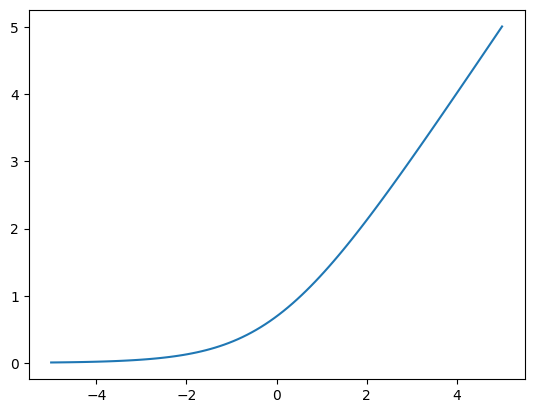

In [3]:
import torch
import torch.nn.functional as F

x = torch.linspace(-5,5,100)
y = F.softplus(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

In [2]:
data_name = "DS03"

experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data


In [3]:
hi_train = pd.read_csv(experiment_dir/'hidata_dev.csv')
perform_alias = [col for col in hi_train.columns if col not in ['unit','cycle']]
units = hi_train['unit'].unique().tolist()

In [4]:
performs_train = {alias: 
    {int(unit): hi_train[hi_train['unit']==unit][alias].values for unit in units} 
    for alias in perform_alias
}
time_train = {int(unit): hi_train[hi_train['unit']==unit]['cycle'].values for unit in units}

## Create Initial Particles (Training)
The number of (pure) particles $N$ is the the number of training trajectories.

### Create initial states

In [5]:
resolution=1024
t_end=160
s = np.linspace(0,1,resolution)
t = np.linspace(0,t_end,resolution)


colors = plt.get_cmap('tab10') 
perform_states={}
perform_train_interp={}
for name,units_perform in performs_train.items():
    states =[]
    perform_interp = []
    for unit,perform in units_perform.items():
        t_train=time_train[unit]
        data=t_train,perform
        model=DistModel(max_s=max(perform))
        criterion=CombinedGammaLoss(seq_len=len(t_train), nll_scale=1,mse_scale=1,alpha=0.50) #scale weighted towards end
        best_model=fit(model,data,criterion,lr=0.001,n_epochs=100000)
        state = np.array(list(best_model.get_parameters(as_float=True))) 
        ParticleFilter.plot_states(
                np.stack(state[np.newaxis,:],axis=0),
                t_end,
                t_train,
                perform,
                multiply_level=None,
                n_particles=None,
                title=name,
                resolution=1024)
        plt.show()
        states.append(state)
        perform_interp.append(data[0])
    perform_states[name]=np.stack(states)
    perform_train_interp[name]=perform_interp

Epoch 1000, Best Loss: 1.4492230415344238
Epoch 2000, Best Loss: 1.3563294410705566
Epoch 3000, Best Loss: 1.2887682914733887
Epoch 4000, Best Loss: 1.2318391799926758
Epoch 5000, Best Loss: 1.1818811893463135
Epoch 6000, Best Loss: 1.13804030418396
Epoch 7000, Best Loss: 1.0996965169906616
Epoch 8000, Best Loss: 1.0663036108016968
Epoch 9000, Best Loss: 1.0373542308807373


KeyboardInterrupt: 

In [ ]:
perform_train_interp={}
for j, (name,units_perform) in enumerate(performs_train.items()):
    if j==0: 
        time_train_interp = []
    perform_interp = []
    for unit,perform in enumerate(units_perform):
        t_interp,s_interp=interpolate(time_train[unit],perform,n_points=20,tilt=3)
        data=s_interp,t_interp
        if j==0: 
            time_train_interp.append(data[1])
        perform_interp.append(data[0])
    perform_train_interp[name]=perform_interp

KeyError: 0

## Save

In [ ]:
with open(f'{exp}/states.pkl', 'wb') as f:
    dump(perform_states,f)
    
with open(f'{exp}/states_data_interp.pkl', 'wb') as f:
    dump((time_train_interp,perform_train_interp),f)

## Load already learned states.

In [ ]:
with open(f'data/{dataset_name}/time_train.pkl', 'rb') as file:
    time_train = load(file)
        
with open(f'data/{dataset_name}/performs_train.pkl', 'rb') as file:
    performs_train  = load(file)
    
with open(f'{exp}/states.pkl', 'rb') as f:
    perform_states=load(f)
    
with open(f'{exp}/states_data_interp.pkl', 'rb') as f:
    states_data_interp = load(f)
time_train_interp,perform_train_interp = states_data_interp

## Show States

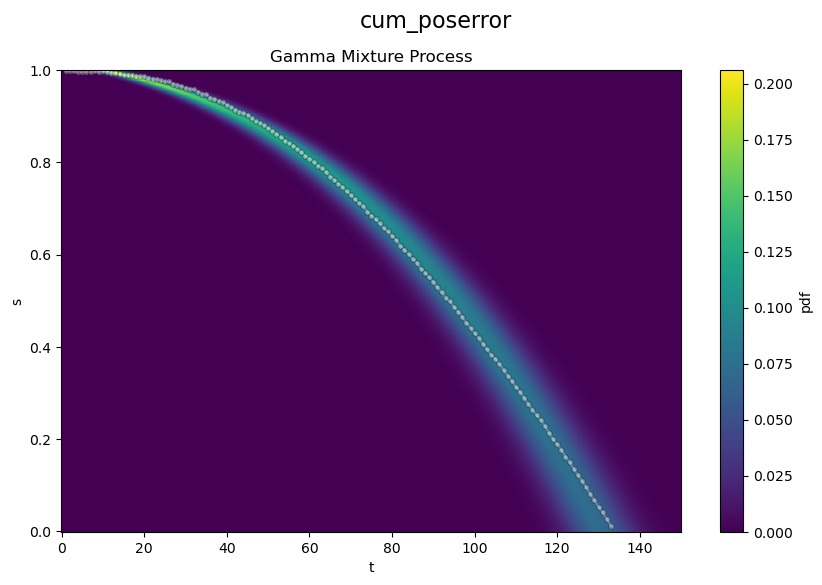

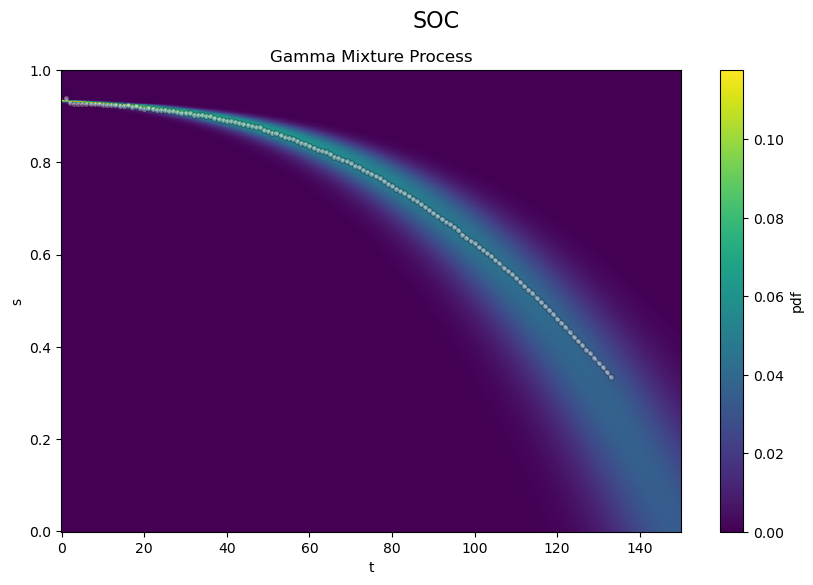

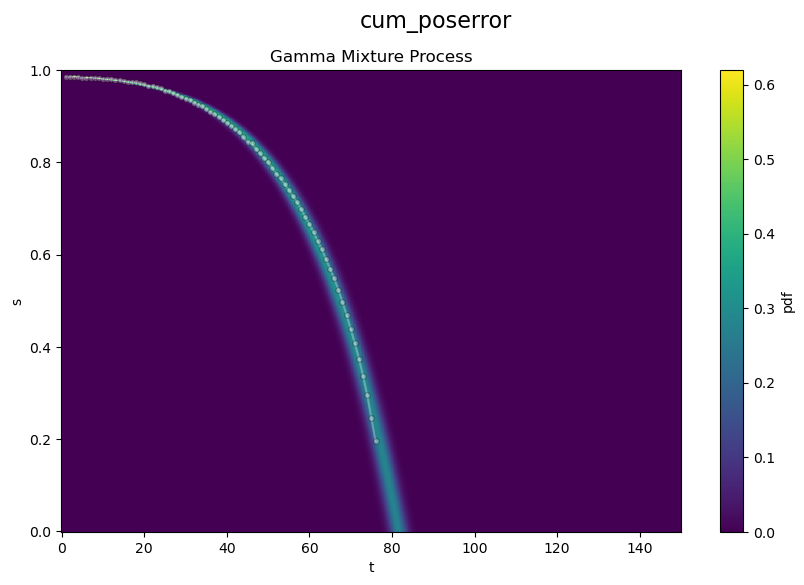

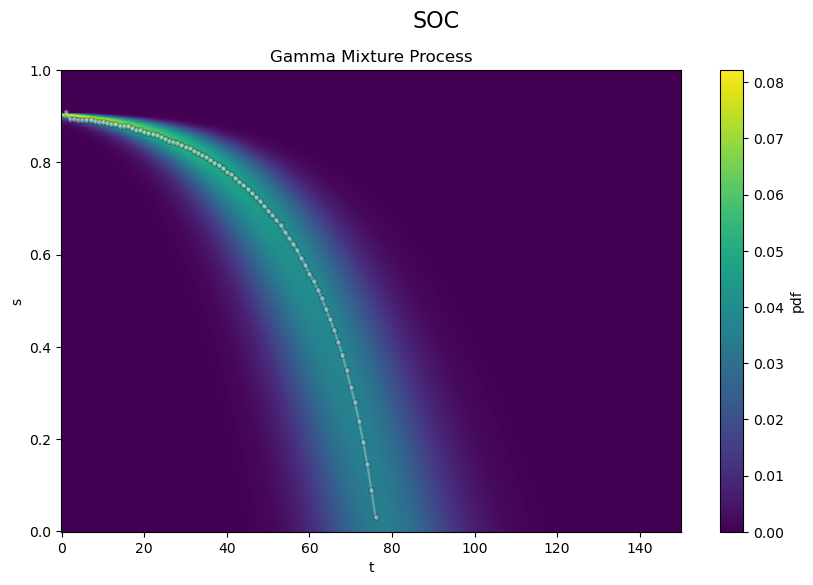

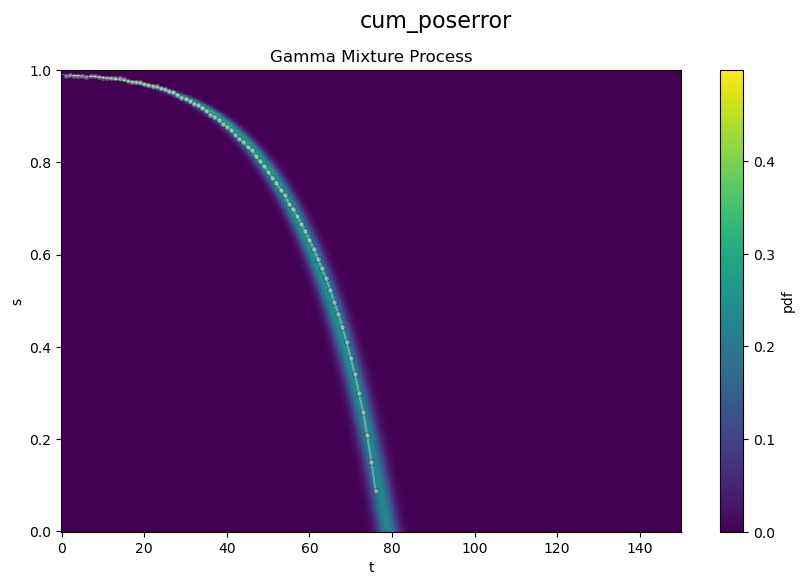

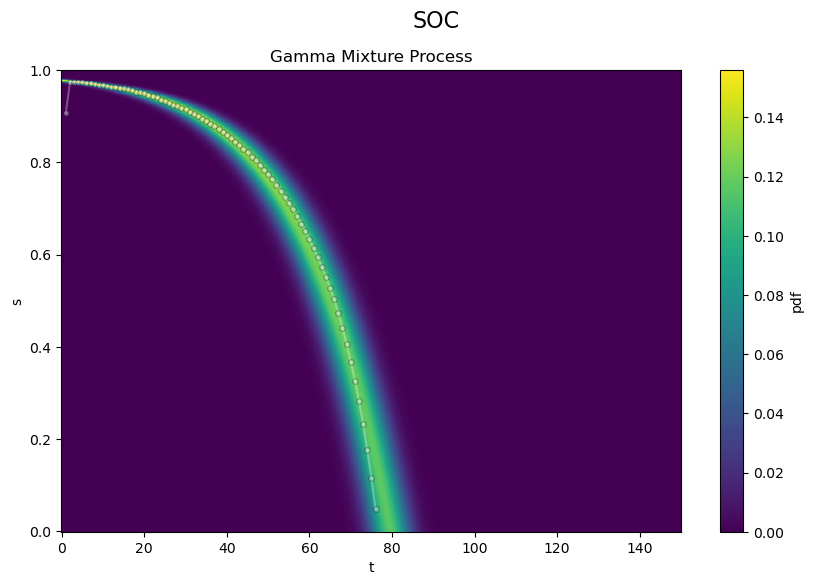

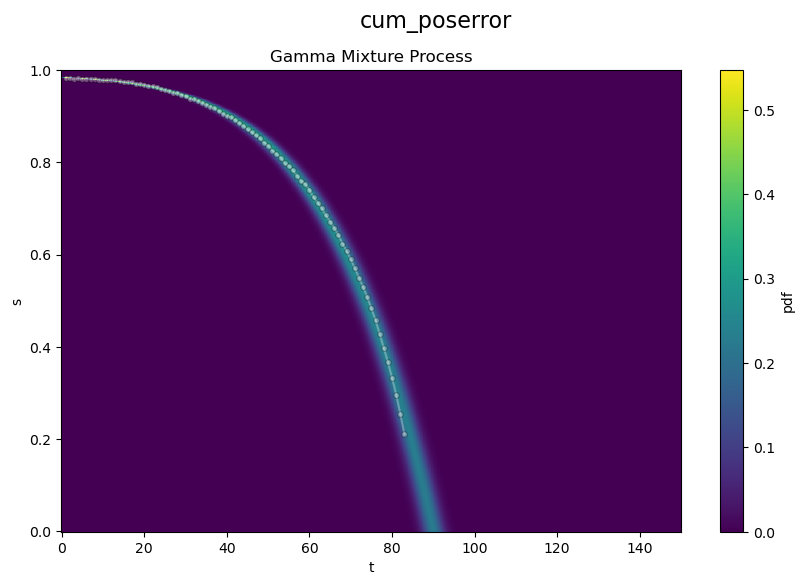

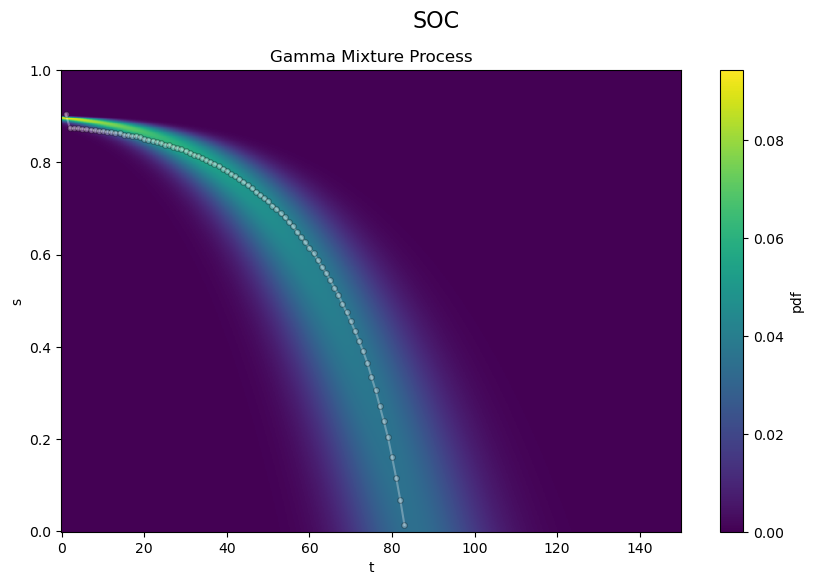

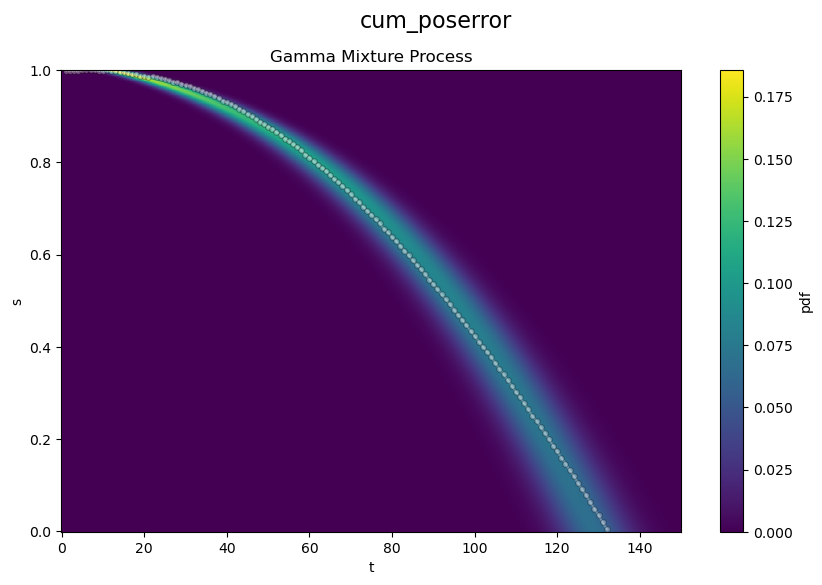

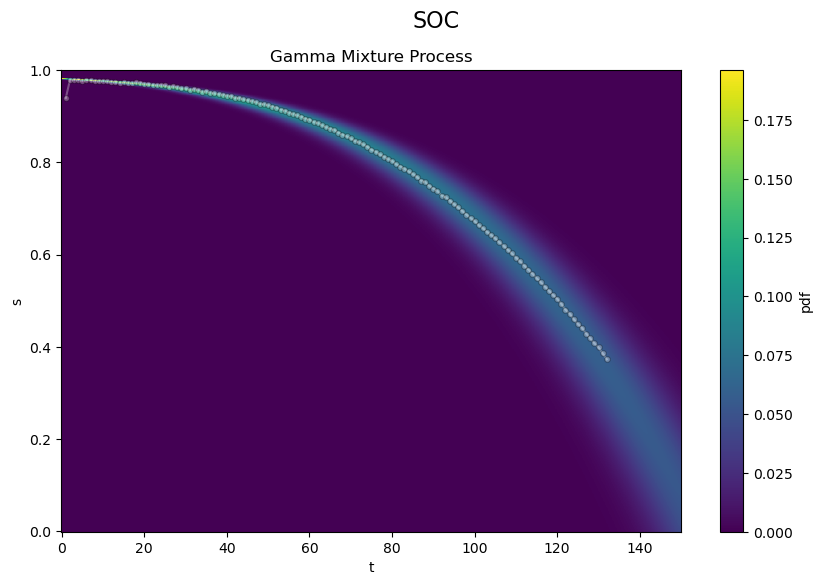

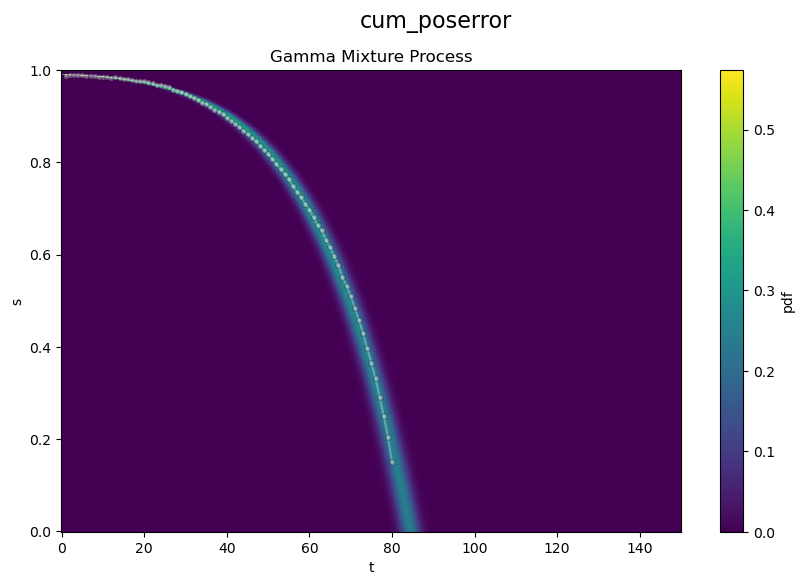

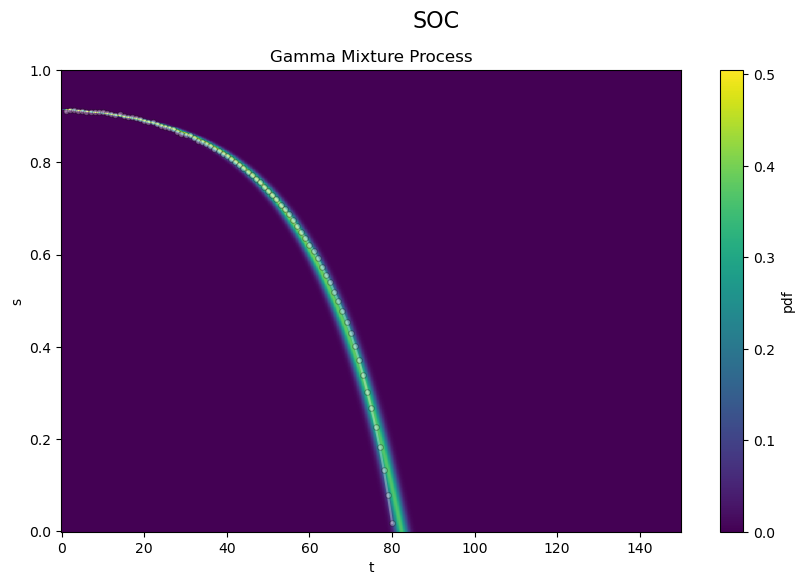

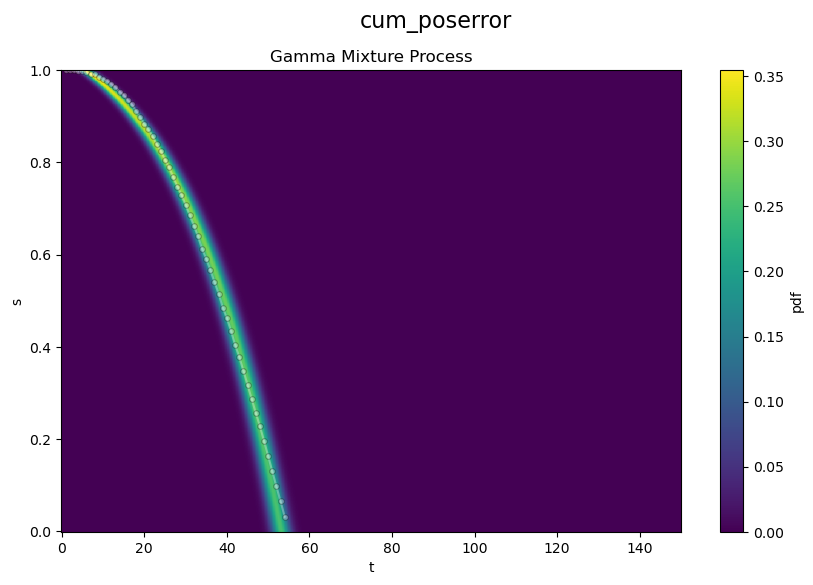

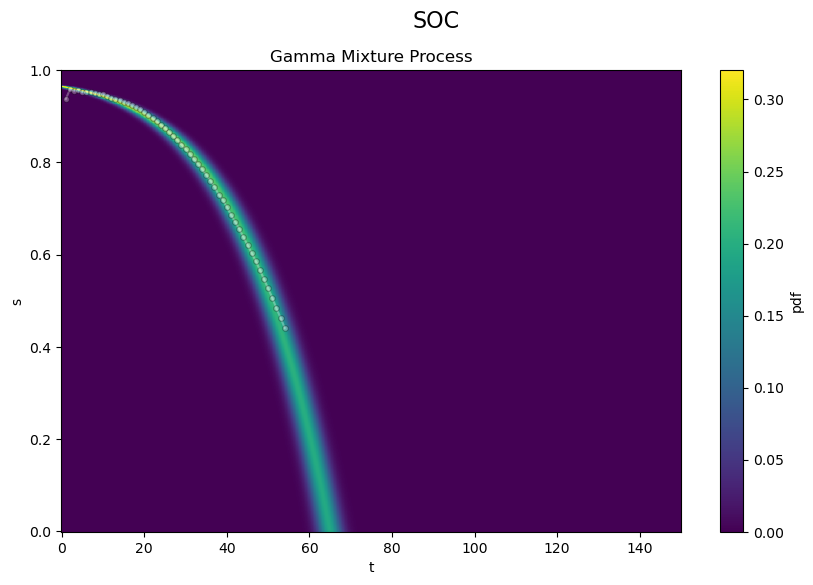

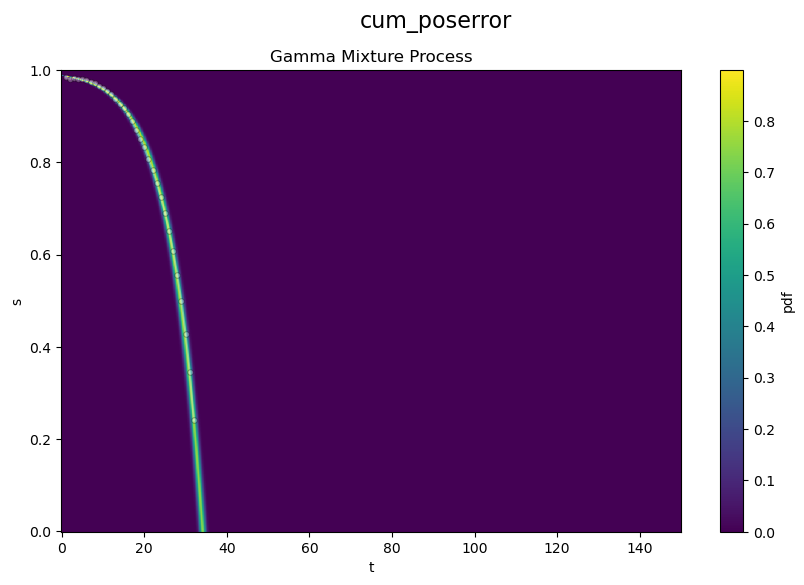

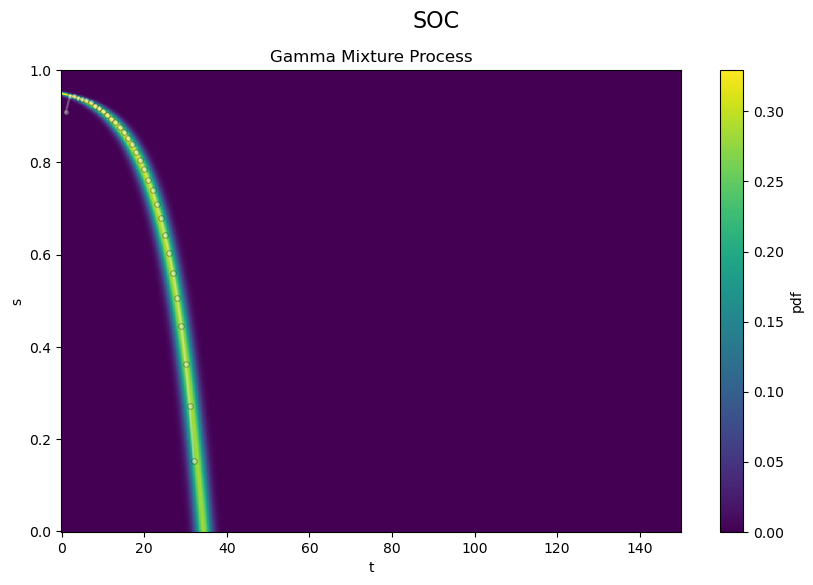

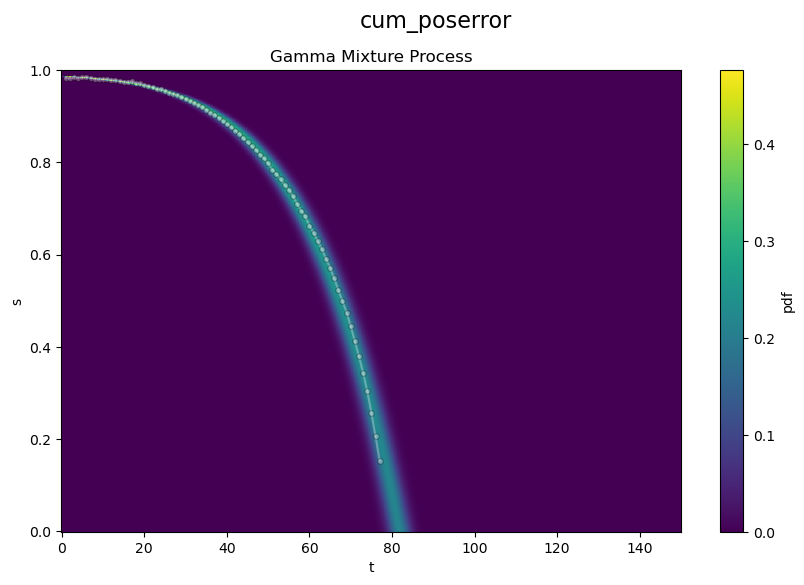

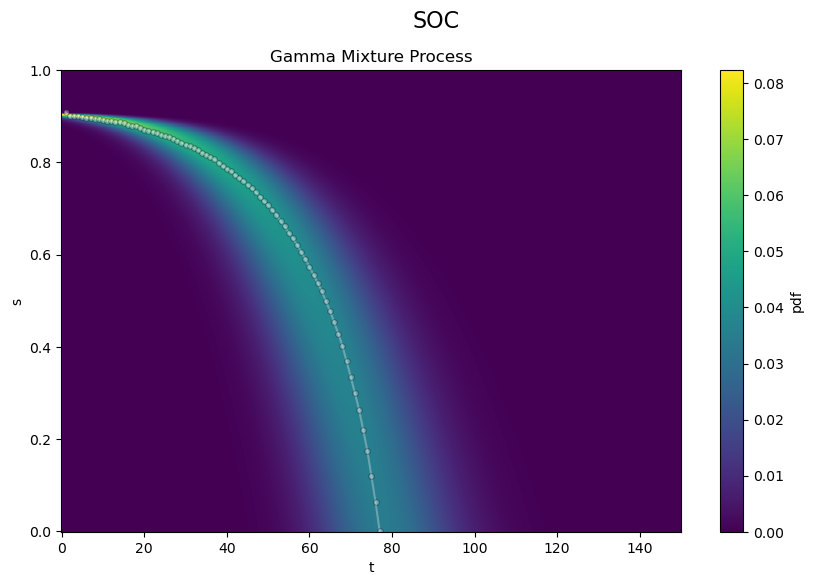

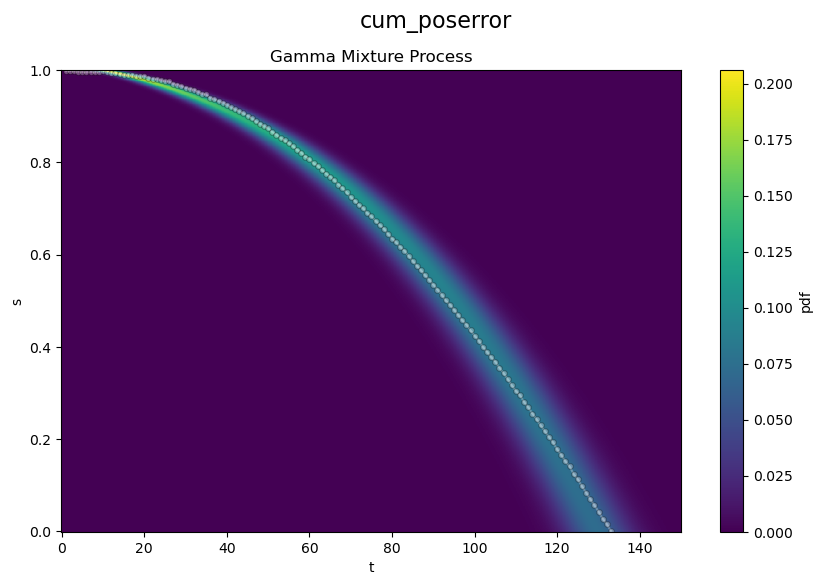

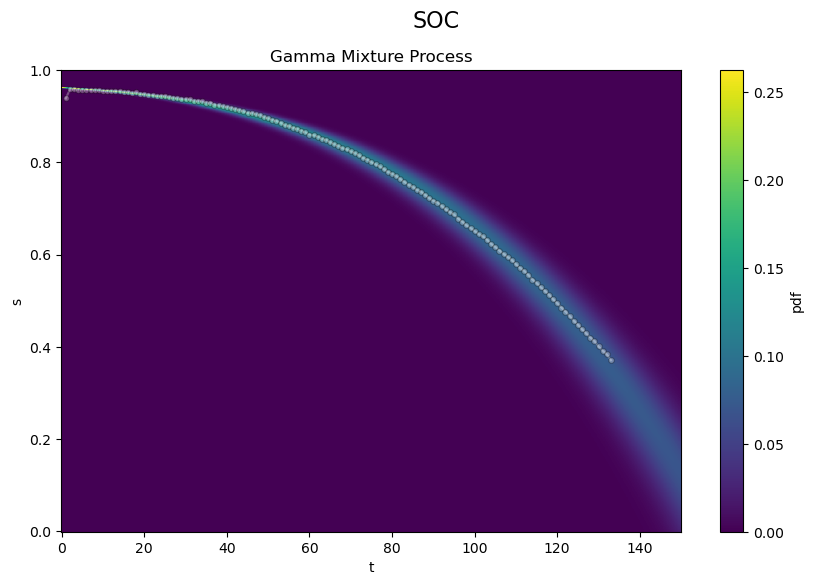

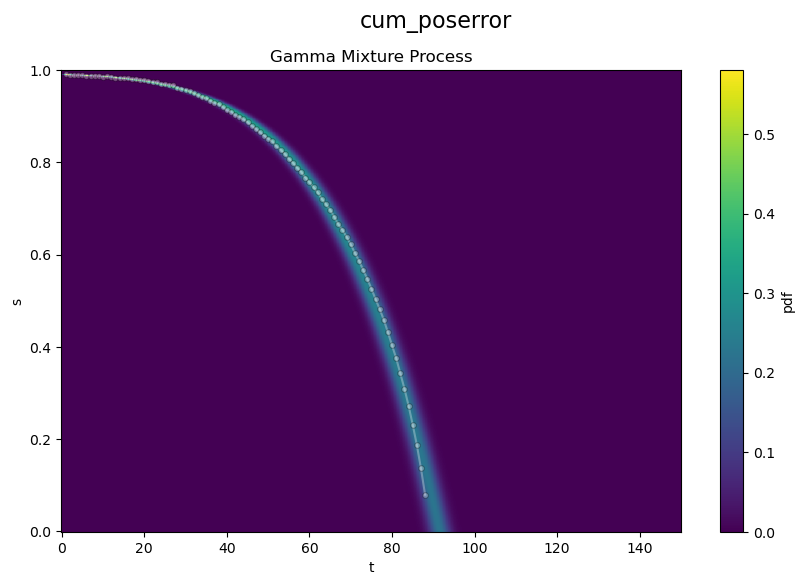

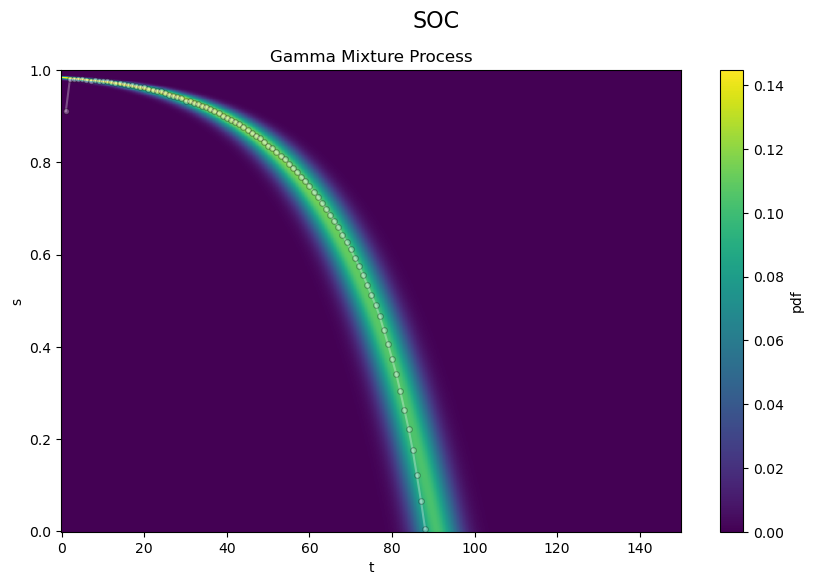

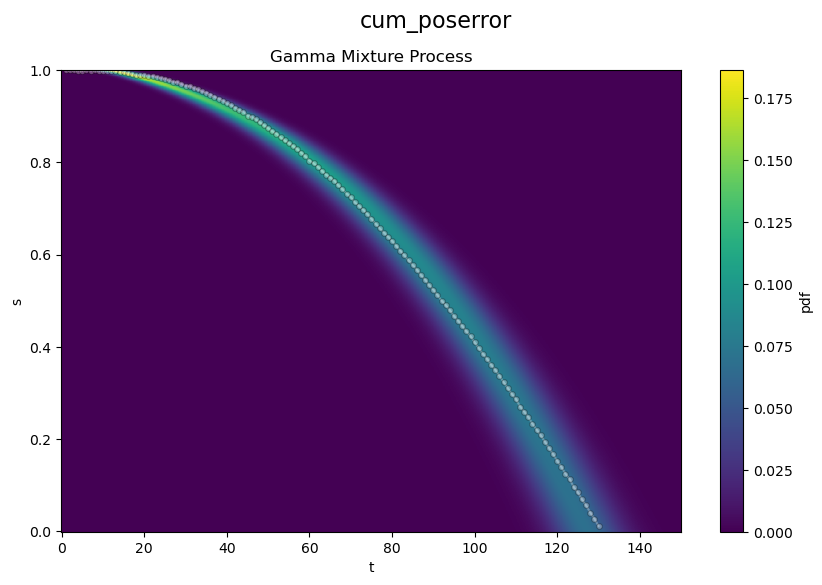

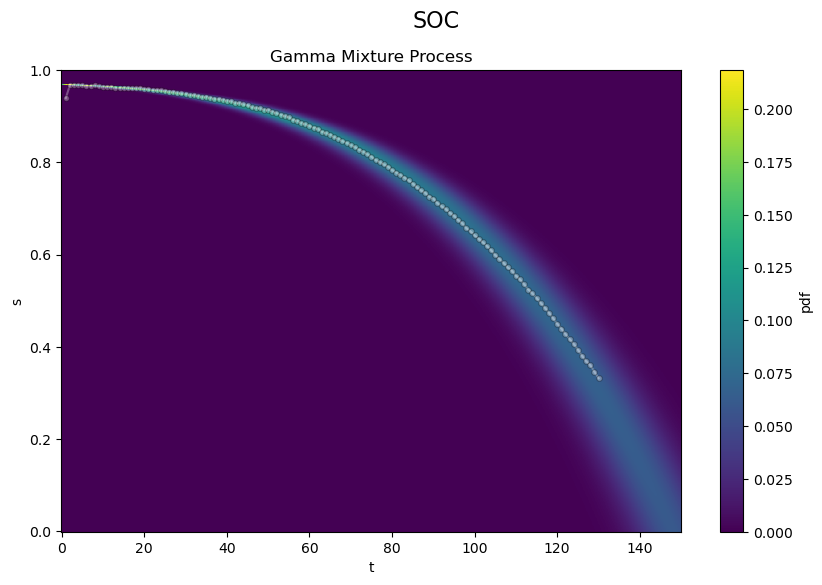

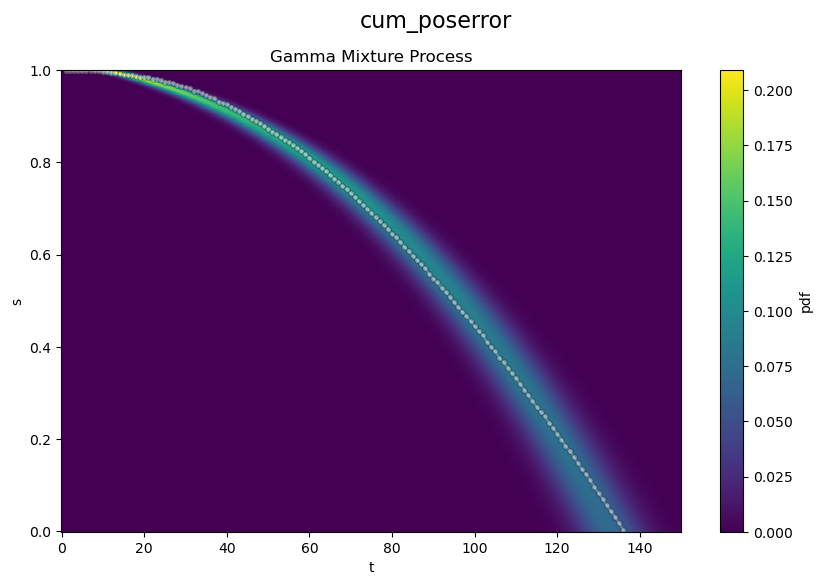

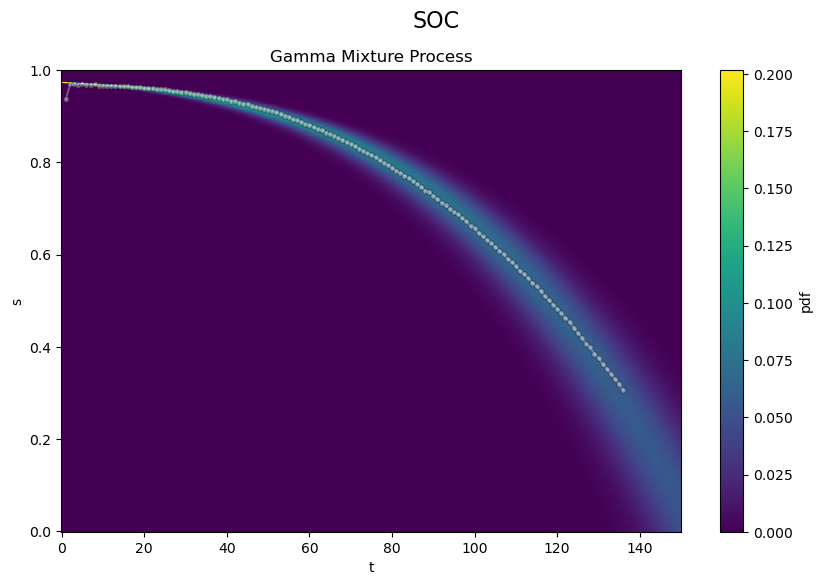

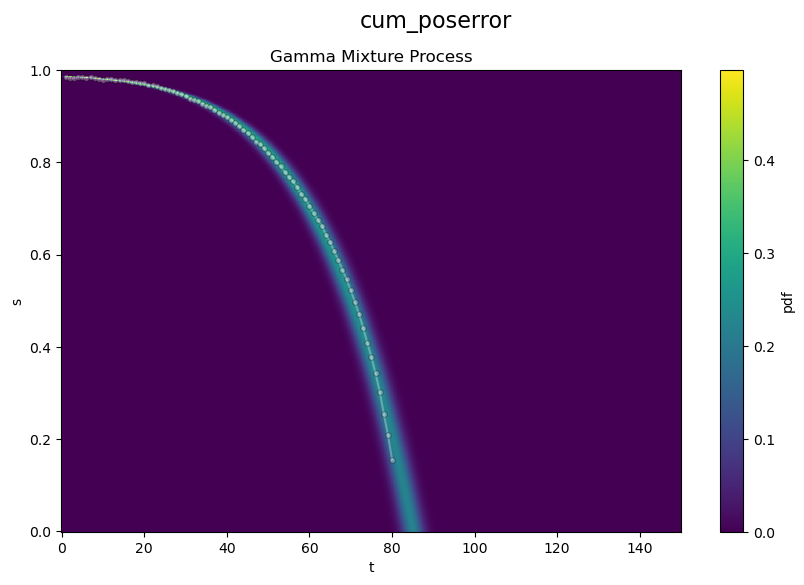

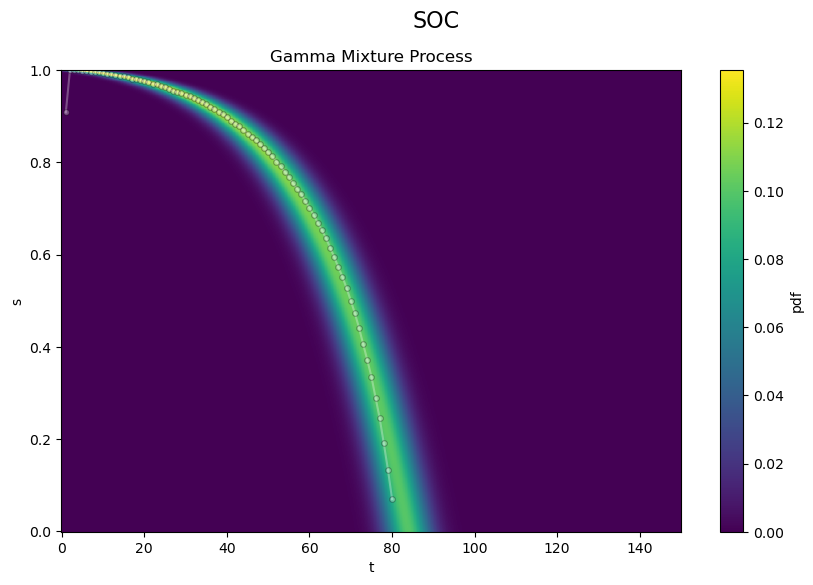

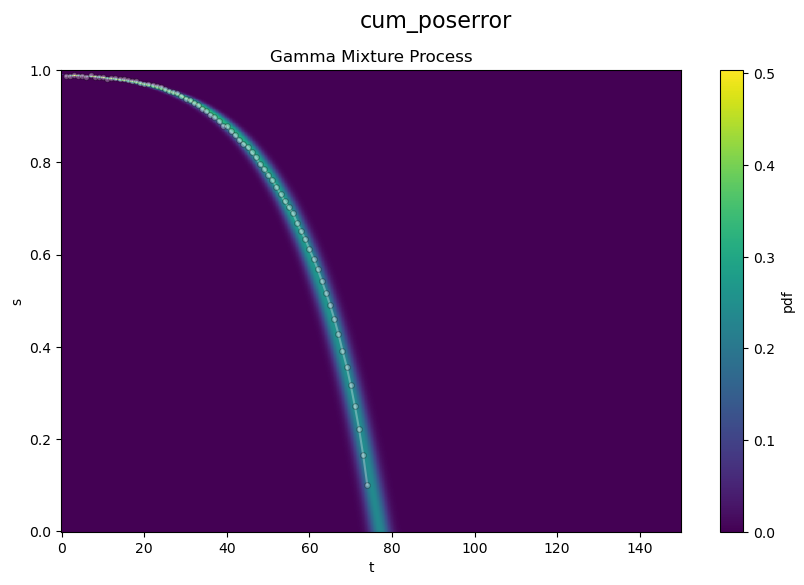

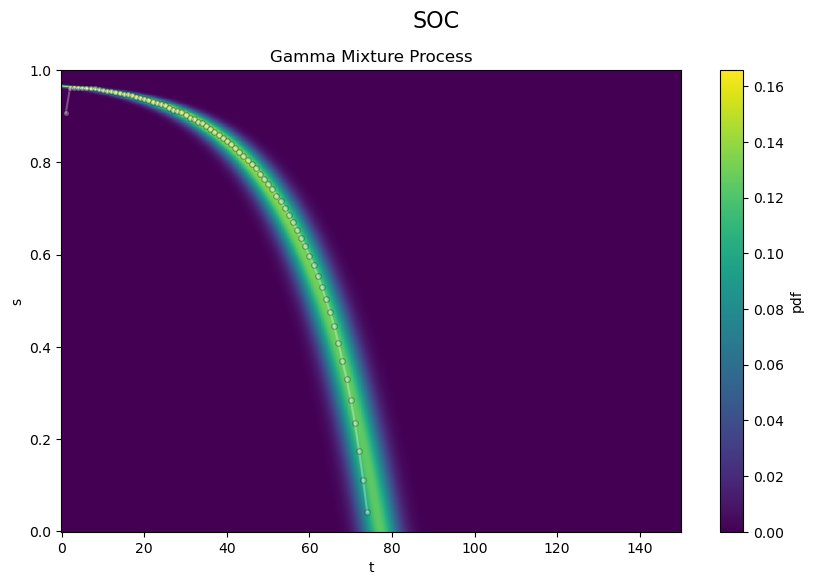

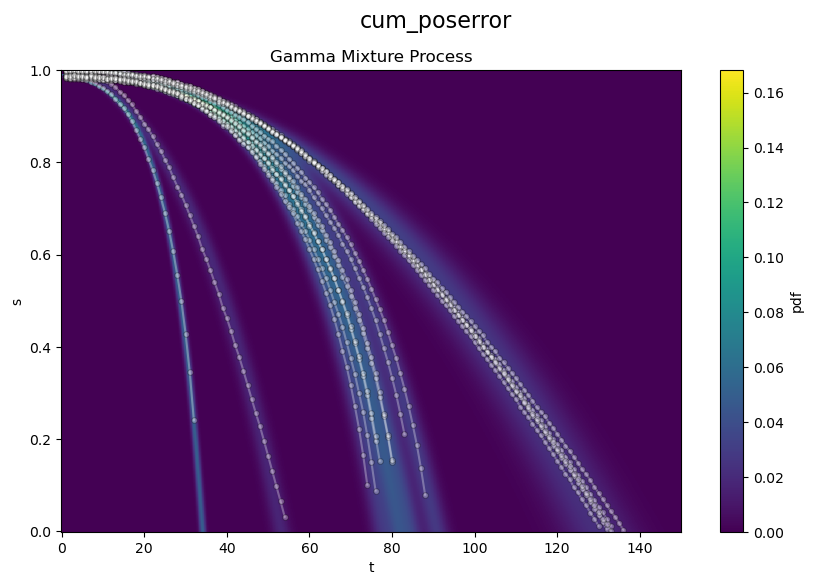

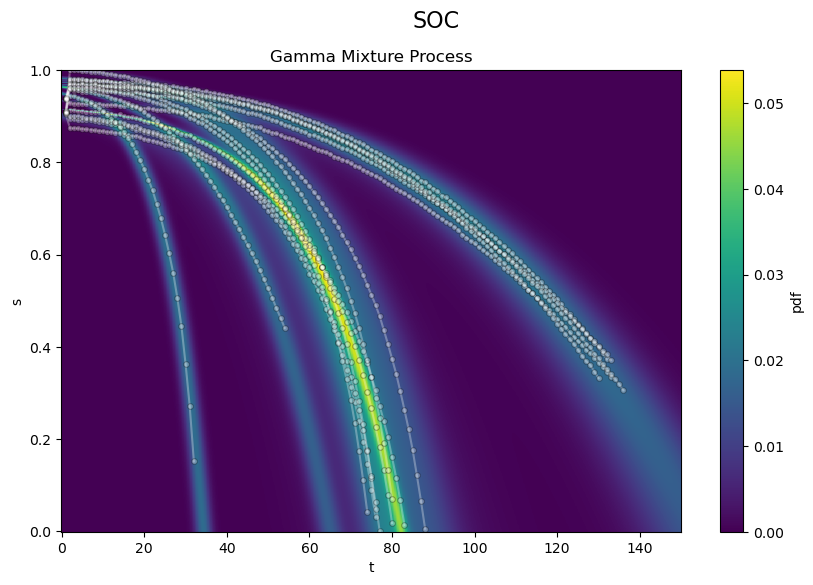

In [ ]:
resolution=1024
t_end=150
s = np.linspace(0,1,resolution)
t = np.linspace(0,t_end,resolution)

for i,t_train in enumerate(time_train):
    for (name,states),perf_train,perf_interp in zip(
        perform_states.items(),
        performs_train.values(),
        perform_train_interp.values()
        ):
        ParticleFilter.plot_states(
                np.stack(states[[i]],axis=0),
                t_end,
                t_train,
                perf_train[i],
                multiply_level=None,
                n_particles=None,
                title=name,
                resolution=1024)
        plt.show()


for (name,states),perf_train,perf_interp in zip(
    perform_states.items(),
    performs_train.values(),
    perform_train_interp.values()
    ):
    ParticleFilter.plot_states(
            np.stack(states,axis=0),
            t_end,
            time_train,
            perf_train,
            multiply_level=None,
            n_particles=None,
            title=name,
            resolution=1024)

## Save States

In [ ]:
with open(f'{exp}/states.pkl', 'wb') as f:
    dump(perform_states, f)
    
states_data_interp=time_train_interp,perform_train_interp
with open(f'{exp}/states_data_interp.pkl', 'wb') as f:
    dump(states_data_interp, f)

## Gamma mixture model 

In [ ]:
gmp_dic={}
for name,states in perform_states.items():
    mean,var,p,pos_mu,a=states.T
    shapes,rates=stats2params(mean,var) 
    N=len(states)
    scales=1/rates
    loc = -pos_mu
    weights=np.ones(N)/N
    gmp_dic[name]=GammaMixtureProcess(shapes,scales,p,loc,a,weights)

## Plots

In [ ]:
resolution=1024
s = np.linspace(0,1,resolution)
t = np.linspace(0,t_end,resolution)

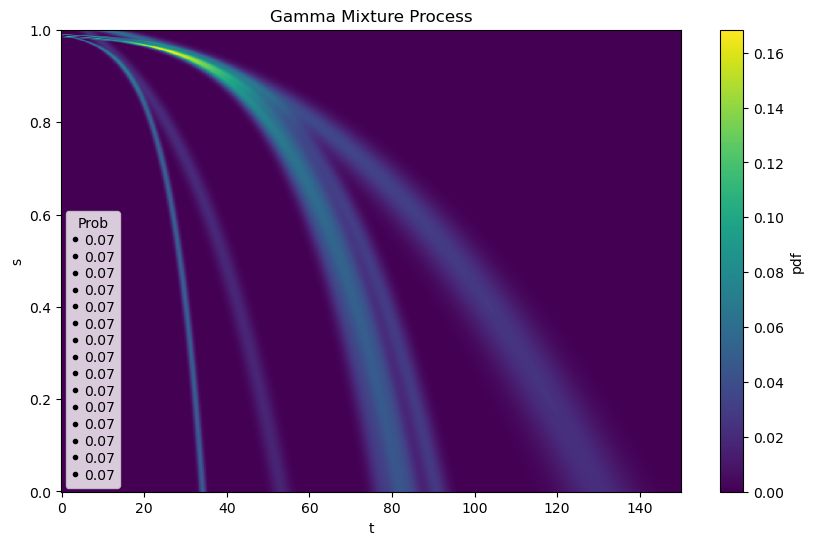

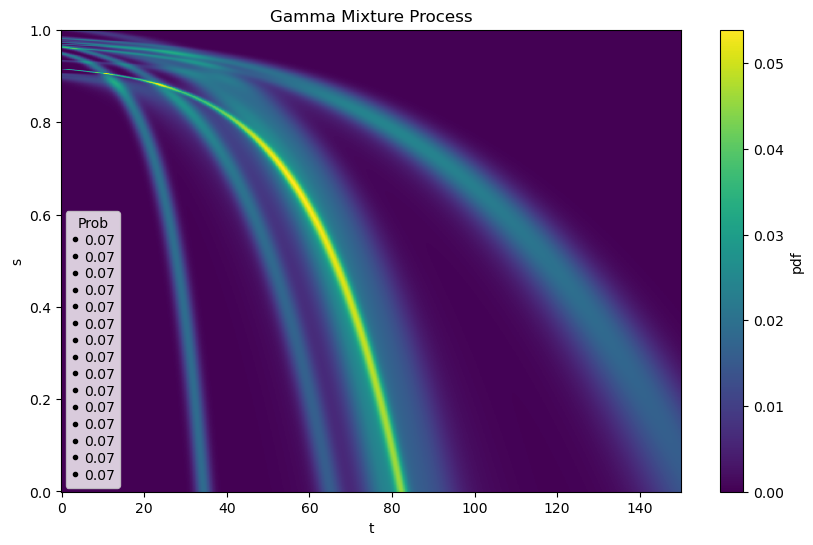

In [ ]:
for model in gmp_dic.values():
    ax=model.plot_dist(t,s,func='pdf',show_prob=True,gamma_prob=1) 
    plt.show()

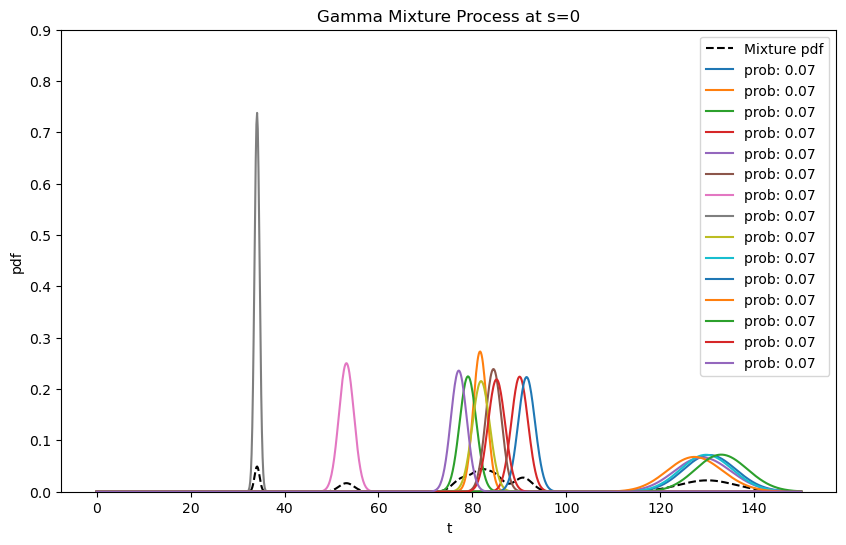

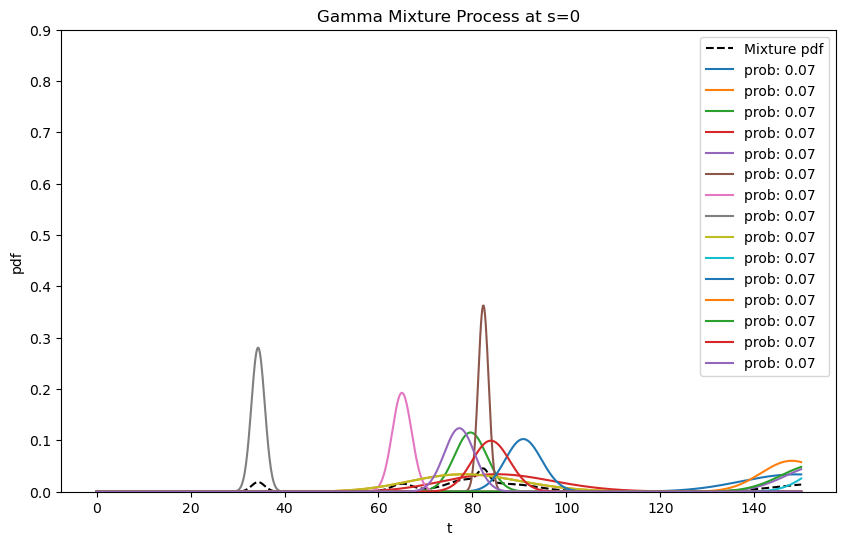

In [ ]:
for model in gmp_dic.values():
    ax=model.plot_rv_dist(t,s=0,func='pdf',show_prob=True,show_comp=True, max_prob=0.9,conf_level=0) 
    plt.show()

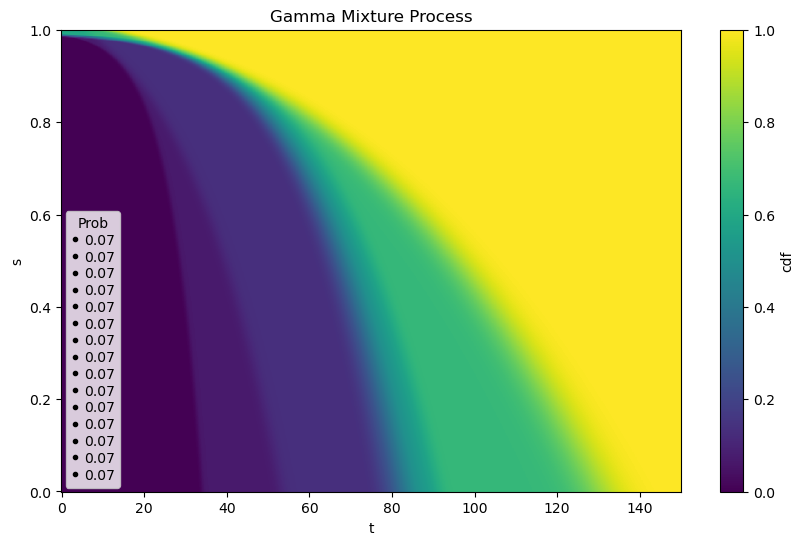

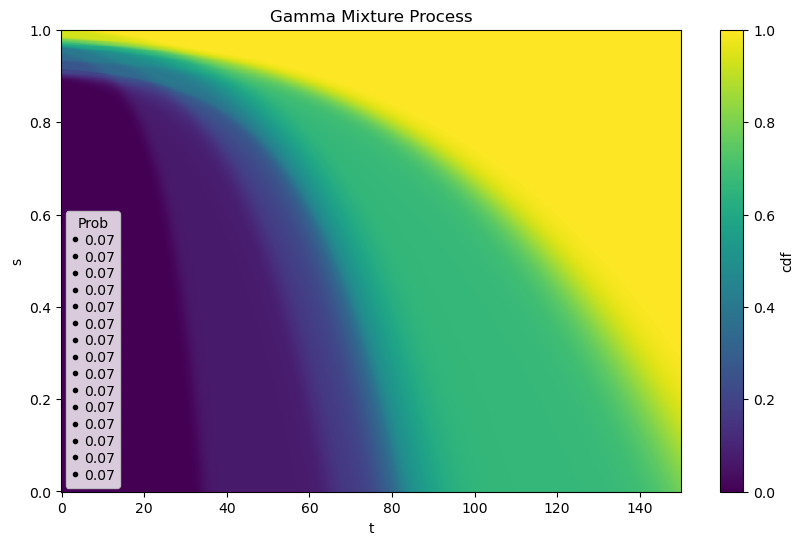

In [ ]:
for model in gmp_dic.values():
    ax=model.plot_dist(t,s,func='cdf',show_prob=True,gamma_prob=1) 
    plt.show()

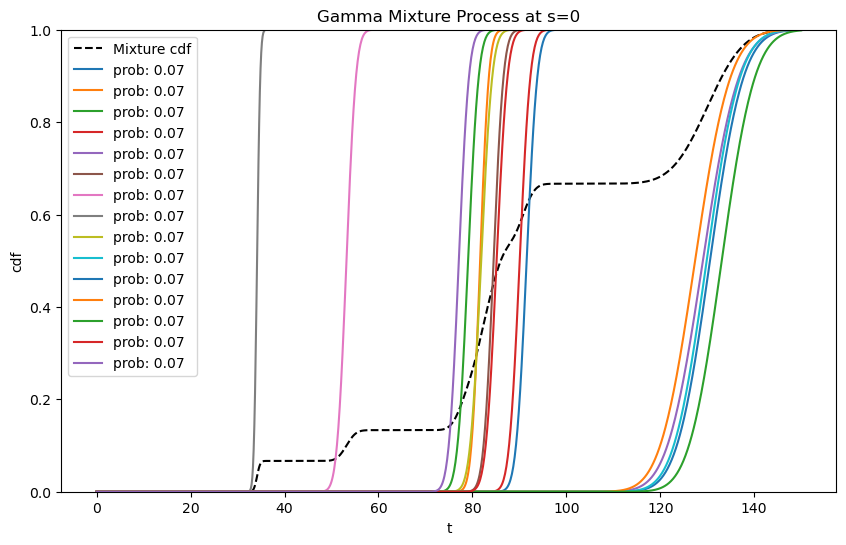

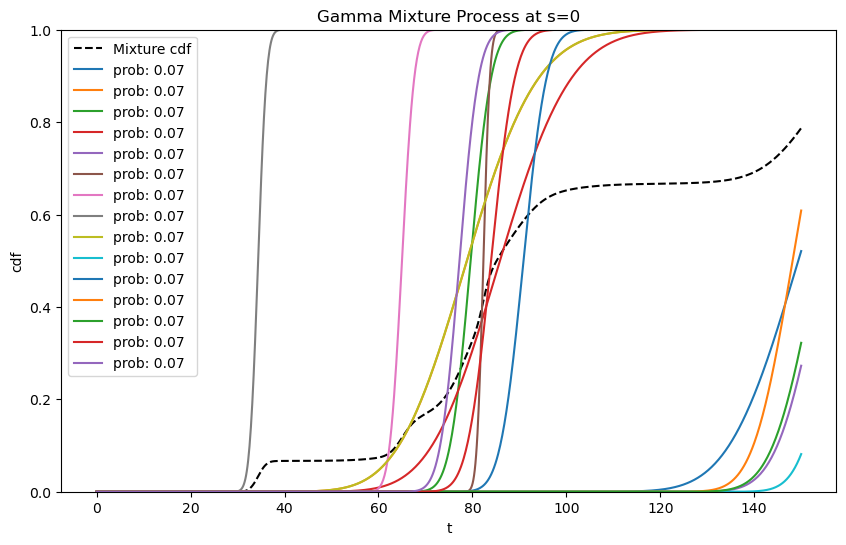

In [ ]:
for model in gmp_dic.values():
    ax=model.plot_rv_dist(t,s=0,func='cdf',show_prob=True,show_comp=True,conf_level=0) 
    plt.show()

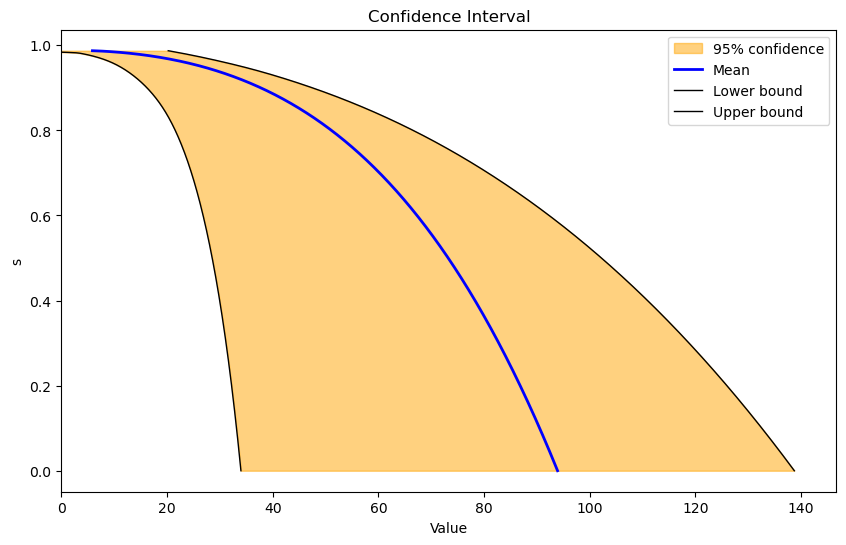

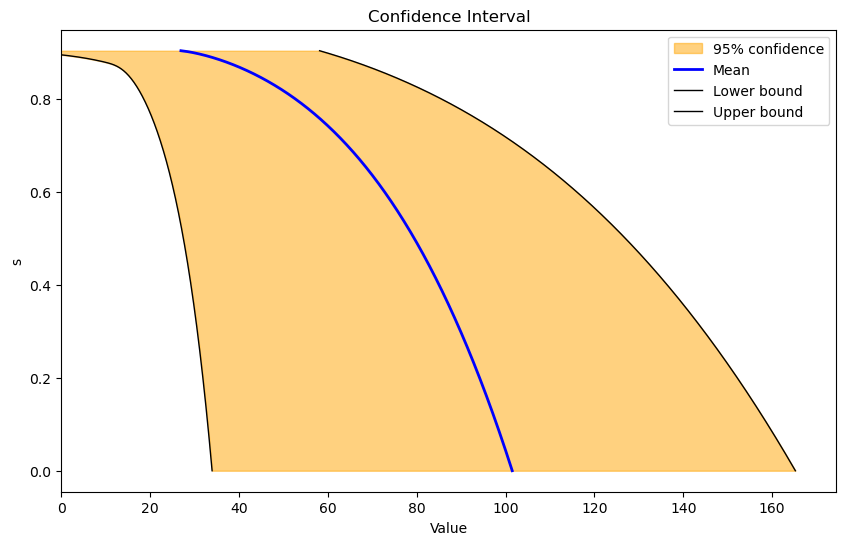

In [ ]:
level = 0.95
for name,model in gmp_dic.items():
    ax = model.plot_conf_interval(s,level=0.95)
    plt.show()

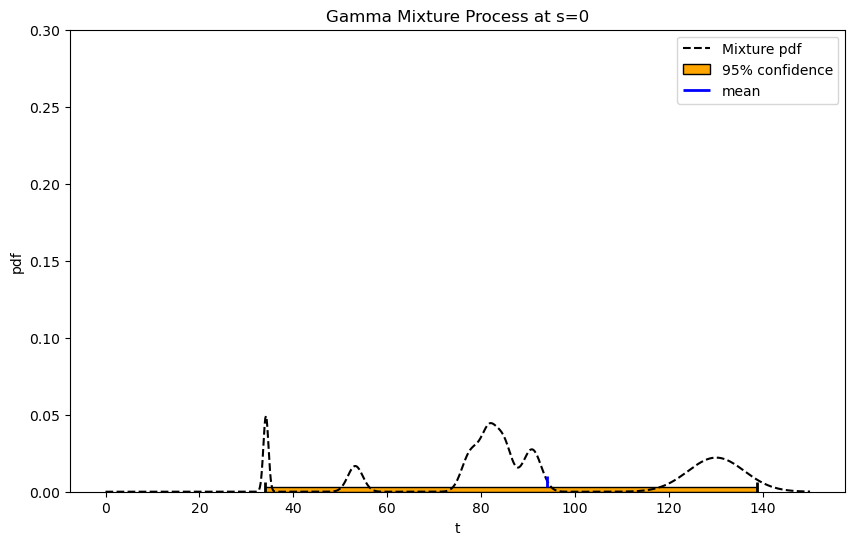

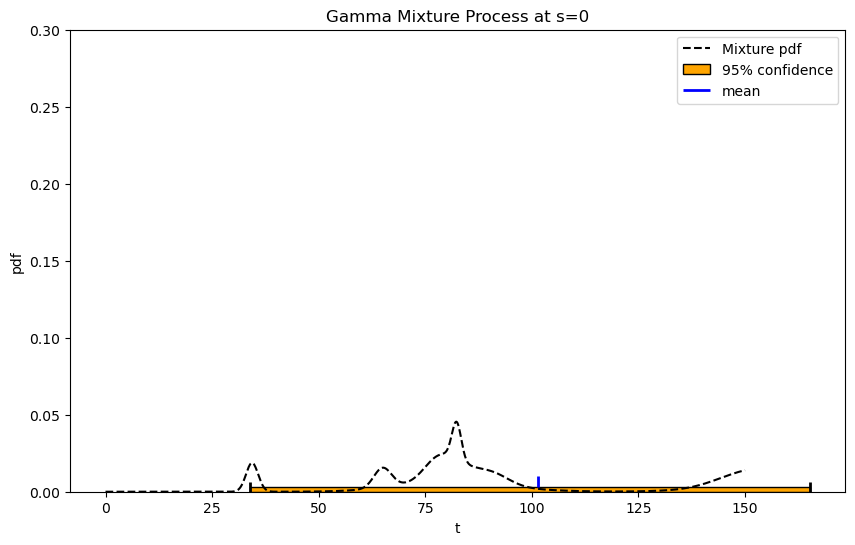

In [ ]:
for model in gmp_dic.values():
    ax=model.plot_rv_dist(t,s=0,func='pdf',show_prob=True,show_comp=False, max_prob=0.3,conf_level=0.95) 
    plt.show()

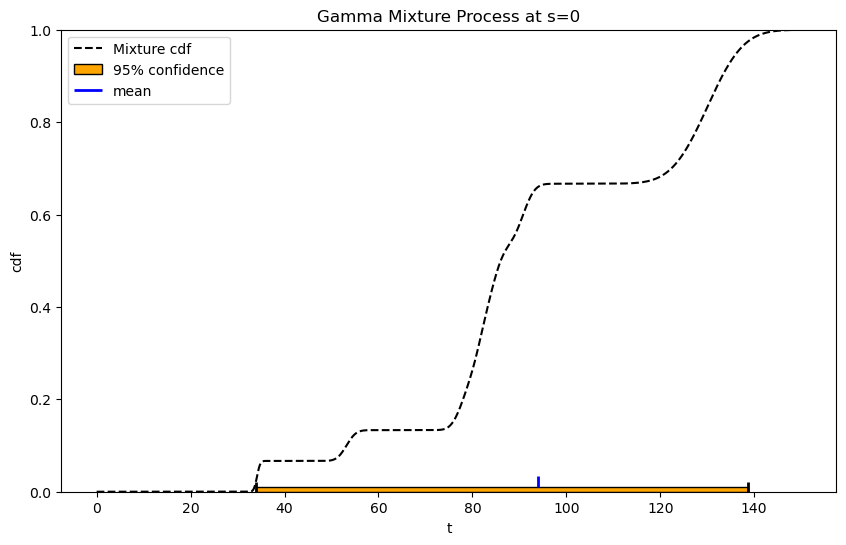

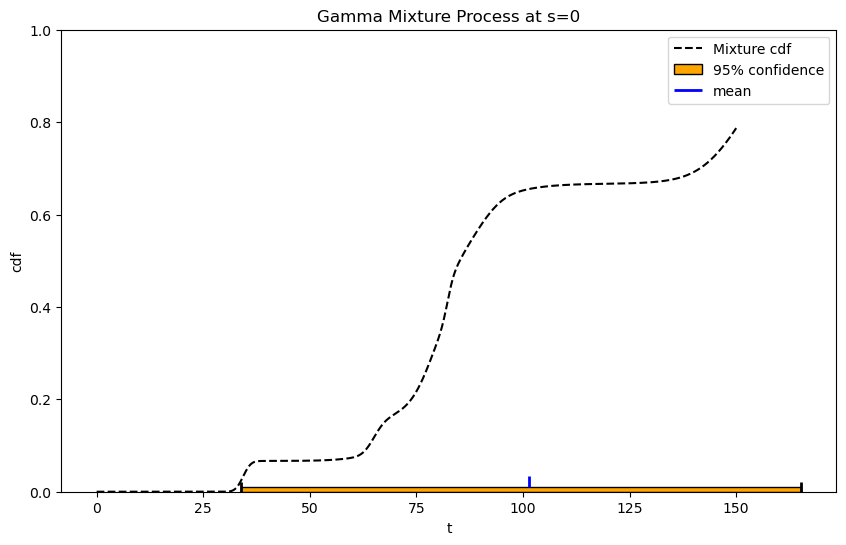

In [ ]:
for model in gmp_dic.values():
    model.plot_rv_dist(t,s=0,func='cdf',show_prob=True,show_comp=False,conf_level=0.95) 